In [1]:
import os
import numpy as np
import pandas as pd
import vame
from align_demo import *

In [2]:
cwd = os.getcwd()
project_name = 'vame_onur'
videos_folder = r"C:\Users\serce\Desktop\vame_trial_videos"
videos = [os.path.join(videos_folder, v) for v in os.listdir(videos_folder)]

In [3]:
config = vame.init_new_project(project=project_name,
                               videos=videos,
                               working_directory=cwd,
                               videotype='.mp4')

Created "C:\Users\serce\PycharmProjects\behaviour-switching\vame_onur-Nov26-2020\videos"
Created "C:\Users\serce\PycharmProjects\behaviour-switching\vame_onur-Nov26-2020\data"
Created "C:\Users\serce\PycharmProjects\behaviour-switching\vame_onur-Nov26-2020\results"
Created "C:\Users\serce\PycharmProjects\behaviour-switching\vame_onur-Nov26-2020\model"
Copying the videos 

A VAME project has been created. 

Next use vame.create_trainset(config) to split your data into a train and test set. 
Afterwards you can use vame.rnn_model() to train the model on your data.


- Transfer the videos and csv files into respective vame project folders
- If you have h5 files, they need to be converted to csv
- video name and the dlc output should have the same name
- dlc output further should have -DC.csv suffix

In [39]:
tracking_data_folder = r"C:\Users\serce\PycharmProjects\behaviour-switching\vame_onur-Nov26-2020\videos\pose_estimation"
for file in os.listdir(tracking_data_folder):
    data = pd.read_hdf(os.path.join(tracking_data_folder, file))
    data.to_csv(os.path.join(tracking_data_folder, file[:-3]+'.csv'))
#     os.remove(os.path.join(tracking_data_folder, file))

- `pose_ref_index` and `pose_flip_ref` should be edited in `align_demo.py` before running the following function
- also watch out for the file name and format expectations
- also the following function needs to be run for each video (simply by changing the filename)

In [47]:
from align_demo import *
""" Happy aligning """
#config parameters
path_to_file = os.path.split(config)[0]+'/'
filename = "chr8_day3"
file_format='.mp4'
crop_size=(300,300)

# call function and save into your VAME data folder
egocentric_time_series = align_demo(path_to_file, filename, file_format, crop_size, use_video=False, check_video=False)
np.save(os.path.join(path_to_file, 'data', filename, filename+'-PE-seq.npy'), egocentric_time_series)

# test plot
import matplotlib.pyplot as plt
# plt.plot(egocentric_time_series.T)

Align frames: 100%|███████████████████████████████████████████████████████████| 108000/108000 [08:18<00:00, 216.56it/s]


- `os.path.join(path_to_file, 'data', filename, filename+'-PE-seq.npy')` can be executed to see where the data is saved
- next step is to run `vame.create_trainset(config)`

`vame.create_trainset(config)` will linear interpolate every NaN in your pose estimation NumPy file and save it in your data folder as `data/video-1/video-1-PE-seq-clean.npy`. This file will be accessed later on from `vame.behavior_segmentation()` to segment your pose data.

In [48]:
vame.create_trainset(config)

Creating training dataset.
Lenght of train data: 172800
Lenght of test data: 43200


Now you can start training your recurrent neural network.

`vame.rnn_model(config, model_name='VAME', pretrained_weights=False, pretrained_model=None)`

The RNN model function takes as input your config file, a string which specifies the name of your model, and in case you want to use a pretrained model you can set pretrained_weights=True and pretrained_model='VAME-pretrained'. The last parameter is a string which is the name of the pretrained model. Note that you can always train a model from scratch and use it later again as pretrained model. However, the model must be explicitly the same.

For this step you need to make sure how many input signals you have, i.e. how many virtual marker did you place on the animal. As an example, if you observe a mouse and have only markers at the nose, back and trail-root, you end up with six signals (x-,y-coordinates). Note, the better your virtual markers are learned the better results VAME will get you. It can, however, cope with some noise in your data.

Another important variable is the time window size from which VAME should make predictions about the behavioral state of the animal. Our camera was shooting with 60 frames per second and we choose the time window to be 30 time steps wide to infer the behavioral state from half a second of data. If you choose the time window too big, the RNN might have troubles with finding a good latent representation. The same goes for too short time windows. For now, we recommend a number between 20 and 40 time steps.

**Once you figured out the number of signals and the time window, please specify this in your `config.yaml`:**

num_features: 12

time_window: 30

The other variable should for the moment stay like they are.

NOTE: This step requires that you have your GPU ready and working. If VAME can not find a GPU it will write an error message.

In [51]:
vame.rnn_model(config, model_name='VAME', pretrained_weights=False, pretrained_model=None)

Train RNN model!
Using CUDA
GPU active: True
GPU used: GeForce GTX 1080
Latent Dimensions: 30, Beta: 1, lr: 0.0005
Initialize train data. Datapoints 172800
Initialize test data. Datapoints 43200
Epoch: 1
Train: 
Epoch: 1.  loss: 1792957.5000
Average Train loss: 444949.7633, MSE-Loss: 223431.4442, MSE-Future-Loss 221518.3192, KL-Loss: 0.0000,  Kmeans-Loss: 0.0000, weigt: 0.0000
Test: 
Average Test loss: 35482.3892, MSE-Loss: 35482.3892, KL-Loss: 0.0000, Kmeans-Loss: 0.0000
lr: 0.0005
Epoch: 2
Train: 


C:\Users\serce\Anaconda3\envs\bsclone\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch: 2.  loss: 170811.2812
Average Train loss: 153617.0034, MSE-Loss: 75266.2262, MSE-Future-Loss 78350.7778, KL-Loss: 0.0000,  Kmeans-Loss: 0.0000, weigt: 0.0000
Test: 
Average Test loss: 28865.1242, MSE-Loss: 28865.1242, KL-Loss: 0.0000, Kmeans-Loss: 0.0000
lr: 0.0005
Epoch: 3
Train: 
Epoch: 3.  loss: 125623.8281
Average Train loss: 106845.9731, MSE-Loss: 52388.8825, MSE-Future-Loss 54457.0906, KL-Loss: 0.0000,  Kmeans-Loss: 0.0000, weigt: 0.0000
Test: 
Average Test loss: 22488.8811, MSE-Loss: 22488.8811, KL-Loss: 0.0000, Kmeans-Loss: 0.0000
lr: 0.0005
Epoch: 4
Train: 
Epoch: 4.  loss: 86321.9141
Average Train loss: 83205.0663, MSE-Loss: 39934.4145, MSE-Future-Loss 43262.9036, KL-Loss: 4.7904,  Kmeans-Loss: 2.9579, weigt: 0.5000
Test: 
Average Test loss: 21099.7063, MSE-Loss: 21093.2130, KL-Loss: 4.7949, Kmeans-Loss: 1.6984
lr: 0.0005
Epoch: 5
Train: 
Epoch: 5.  loss: 78786.8438
Average Train loss: 74515.4026, MSE-Loss: 35172.7069, MSE-Future-Loss 39331.5926, KL-Loss: 7.1352,  Kmea

Average Test loss: 7638.8547, MSE-Loss: 7593.8862, KL-Loss: 35.5791, Kmeans-Loss: 9.3895
lr: 0.0005
Saving model!

Epoch: 30
Train: 
Epoch: 30.  loss: 21941.0254
Average Train loss: 23557.9187, MSE-Loss: 8734.1983, MSE-Future-Loss 14772.6463, KL-Loss: 39.4222,  Kmeans-Loss: 11.6519, weigt: 1.0000
Test: 
Average Test loss: 7599.6252, MSE-Loss: 7553.7093, KL-Loss: 36.3746, Kmeans-Loss: 9.5412
lr: 0.0005
Saving model!

Epoch: 31
Train: 
Epoch: 31.  loss: 21884.8340
Average Train loss: 22946.5211, MSE-Loss: 8455.5787, MSE-Future-Loss 14439.1108, KL-Loss: 40.0669,  Kmeans-Loss: 11.7647, weigt: 1.0000
Test: 
Average Test loss: 7641.3659, MSE-Loss: 7595.2707, KL-Loss: 36.5099, Kmeans-Loss: 9.5853
lr: 0.0005
Epoch: 32
Train: 
Epoch: 32.  loss: 21838.7969
Average Train loss: 22776.9411, MSE-Loss: 8343.9965, MSE-Future-Loss 14380.3594, KL-Loss: 40.7163,  Kmeans-Loss: 11.8688, weigt: 1.0000
Test: 
Average Test loss: 7558.6628, MSE-Loss: 7511.6301, KL-Loss: 37.2979, Kmeans-Loss: 9.7348
lr: 0.0005


Epoch: 57.  loss: 18062.2402
Average Train loss: 19145.0127, MSE-Loss: 6584.9442, MSE-Future-Loss 12495.5292, KL-Loss: 50.8630,  Kmeans-Loss: 13.6763, weigt: 1.0000
Test: 
Average Test loss: 6381.6522, MSE-Loss: 6323.3731, KL-Loss: 46.6184, Kmeans-Loss: 11.6607
lr: 0.0005
Epoch: 58
Train: 
Epoch: 58.  loss: 19042.6328
Average Train loss: 18958.1391, MSE-Loss: 6500.8746, MSE-Future-Loss 12392.2152, KL-Loss: 51.3141,  Kmeans-Loss: 13.7353, weigt: 1.0000
Test: 
Average Test loss: 6408.2237, MSE-Loss: 6349.3851, KL-Loss: 47.0722, Kmeans-Loss: 11.7663
lr: 0.0005
Epoch: 59
Train: 
Epoch: 59.  loss: 19243.2637
Average Train loss: 18817.2745, MSE-Loss: 6460.6173, MSE-Future-Loss 12291.0759, KL-Loss: 51.7811,  Kmeans-Loss: 13.8003, weigt: 1.0000
Test: 
Average Test loss: 6287.2924, MSE-Loss: 6228.2916, KL-Loss: 47.1913, Kmeans-Loss: 11.8095
lr: 0.0005
Saving model!

Epoch: 60
Train: 
Epoch: 60.  loss: 18170.0410
Average Train loss: 18898.9810, MSE-Loss: 6479.4957, MSE-Future-Loss 12353.3450, KL

Epoch: 85.  loss: 16734.4531
Average Train loss: 16605.6993, MSE-Loss: 5370.6146, MSE-Future-Loss 11160.0995, KL-Loss: 59.8367,  Kmeans-Loss: 15.1486, weigt: 1.0000
Test: 
Average Test loss: 5757.5764, MSE-Loss: 5689.3193, KL-Loss: 54.9747, Kmeans-Loss: 13.2823
lr: 0.0005
Epoch: 86
Train: 
Epoch: 86.  loss: 15956.9014
Average Train loss: 16653.8357, MSE-Loss: 5351.1836, MSE-Future-Loss 11227.3697, KL-Loss: 60.0887,  Kmeans-Loss: 15.1938, weigt: 1.0000
Test: 
Average Test loss: 5615.6441, MSE-Loss: 5547.4338, KL-Loss: 54.9014, Kmeans-Loss: 13.3089
lr: 0.0005
Saving model!

Epoch: 87
Train: 
Epoch: 87.  loss: 15901.9600
Average Train loss: 16613.6812, MSE-Loss: 5335.3000, MSE-Future-Loss 11202.9738, KL-Loss: 60.1814,  Kmeans-Loss: 15.2262, weigt: 1.0000
Test: 
Average Test loss: 5468.1422, MSE-Loss: 5399.3419, KL-Loss: 55.4221, Kmeans-Loss: 13.3780
lr: 0.0005
Saving model!

Epoch: 88
Train: 
Epoch: 88.  loss: 16104.6416
Average Train loss: 16577.0553, MSE-Loss: 5308.5457, MSE-Future-Loss

Epoch: 113.  loss: 15109.3086
Average Train loss: 15606.4802, MSE-Loss: 4899.5734, MSE-Future-Loss 10626.9724, KL-Loss: 64.0170,  Kmeans-Loss: 15.9174, weigt: 1.0000
Test: 
Average Test loss: 5005.8306, MSE-Loss: 4933.0520, KL-Loss: 58.7202, Kmeans-Loss: 14.0584
lr: 0.0001
Saving model!

Epoch: 114
Train: 
Epoch: 114.  loss: 14526.1924
Average Train loss: 15526.5898, MSE-Loss: 4848.8133, MSE-Future-Loss 10597.7561, KL-Loss: 64.1046,  Kmeans-Loss: 15.9158, weigt: 1.0000
Test: 
Average Test loss: 5092.1444, MSE-Loss: 5019.4290, KL-Loss: 58.6598, Kmeans-Loss: 14.0555
lr: 0.0001
Epoch: 115
Train: 
Epoch: 115.  loss: 15498.8311
Average Train loss: 15295.3305, MSE-Loss: 4808.8851, MSE-Future-Loss 10406.3032, KL-Loss: 64.2000,  Kmeans-Loss: 15.9421, weigt: 1.0000
Test: 
Average Test loss: 5105.2717, MSE-Loss: 5032.2532, KL-Loss: 58.9293, Kmeans-Loss: 14.0892
lr: 0.0001
Epoch: 116
Train: 
Epoch: 116.  loss: 14907.7256
Average Train loss: 15675.5339, MSE-Loss: 4875.5200, MSE-Future-Loss 10720.0

Epoch: 141.  loss: 14193.5303
Average Train loss: 15231.0540, MSE-Loss: 4710.6830, MSE-Future-Loss 10438.3437, KL-Loss: 65.8502,  Kmeans-Loss: 16.1771, weigt: 1.0000
Test: 
Average Test loss: 5062.6386, MSE-Loss: 4988.0023, KL-Loss: 60.3211, Kmeans-Loss: 14.3152
lr: 0.0001
Epoch: 142
Train: 
Epoch: 142.  loss: 15209.2422
Average Train loss: 15259.2413, MSE-Loss: 4750.6906, MSE-Future-Loss 10426.3065, KL-Loss: 66.0518,  Kmeans-Loss: 16.1924, weigt: 1.0000
Test: 
Average Test loss: 5143.0889, MSE-Loss: 5068.2058, KL-Loss: 60.5418, Kmeans-Loss: 14.3413
lr: 0.0001
Epoch: 143
Train: 
Epoch: 143.  loss: 14583.9355
Average Train loss: 15211.9008, MSE-Loss: 4650.0561, MSE-Future-Loss 10479.6900, KL-Loss: 65.9750,  Kmeans-Loss: 16.1799, weigt: 1.0000
Test: 
Average Test loss: 5175.2794, MSE-Loss: 5100.4550, KL-Loss: 60.4801, Kmeans-Loss: 14.3442
lr: 0.0001
Epoch: 144
Train: 
Epoch: 144.  loss: 14198.9014
Average Train loss: 15107.7799, MSE-Loss: 4690.4058, MSE-Future-Loss 10335.0955, KL-Loss: 6

Epoch: 169.  loss: 15150.6338
Average Train loss: 15105.1989, MSE-Loss: 4679.2173, MSE-Future-Loss 10341.9422, KL-Loss: 67.6139,  Kmeans-Loss: 16.4255, weigt: 1.0000
Test: 
Average Test loss: 4956.2470, MSE-Loss: 4879.3303, KL-Loss: 62.2979, Kmeans-Loss: 14.6188
lr: 0.0001
Saving model!

Epoch: 170
Train: 
Epoch: 170.  loss: 14464.5400
Average Train loss: 14910.4614, MSE-Loss: 4613.2386, MSE-Future-Loss 10213.0418, KL-Loss: 67.7427,  Kmeans-Loss: 16.4383, weigt: 1.0000
Test: 
Average Test loss: 5012.1948, MSE-Loss: 4935.5921, KL-Loss: 61.9906, Kmeans-Loss: 14.6121
lr: 0.0001
Epoch: 171
Train: 
Epoch: 171.  loss: 14192.7090
Average Train loss: 14841.2162, MSE-Loss: 4614.5393, MSE-Future-Loss 10142.5559, KL-Loss: 67.6914,  Kmeans-Loss: 16.4296, weigt: 1.0000
Test: 
Average Test loss: 5023.0476, MSE-Loss: 4946.3645, KL-Loss: 62.0715, Kmeans-Loss: 14.6115
lr: 0.0001
Epoch: 172
Train: 
Epoch: 172.  loss: 13951.1504
Average Train loss: 15027.6483, MSE-Loss: 4657.1556, MSE-Future-Loss 10286.2

Epoch: 197.  loss: 14135.3428
Average Train loss: 14828.8769, MSE-Loss: 4586.2779, MSE-Future-Loss 10156.7512, KL-Loss: 69.1943,  Kmeans-Loss: 16.6536, weigt: 1.0000
Test: 
Average Test loss: 4992.5496, MSE-Loss: 4914.3965, KL-Loss: 63.3190, Kmeans-Loss: 14.8342
lr: 0.0001
Epoch: 198
Train: 
Epoch: 198.  loss: 14708.3809
Average Train loss: 14771.1811, MSE-Loss: 4547.2433, MSE-Future-Loss 10138.0724, KL-Loss: 69.1980,  Kmeans-Loss: 16.6673, weigt: 1.0000
Test: 
Average Test loss: 4893.2508, MSE-Loss: 4815.0684, KL-Loss: 63.3475, Kmeans-Loss: 14.8348
lr: 0.0001
Epoch: 199
Train: 
Epoch: 199.  loss: 14504.8760
Average Train loss: 14629.9012, MSE-Loss: 4543.8500, MSE-Future-Loss 10000.1084, KL-Loss: 69.2855,  Kmeans-Loss: 16.6574, weigt: 1.0000
Test: 
Average Test loss: 4913.0366, MSE-Loss: 4834.9545, KL-Loss: 63.2451, Kmeans-Loss: 14.8369
lr: 0.0001
Epoch: 200
Train: 
Epoch: 200.  loss: 14909.1182
Average Train loss: 14761.6561, MSE-Loss: 4519.2349, MSE-Future-Loss 10156.5276, KL-Loss: 6

Average Train loss: 14605.7838, MSE-Loss: 4523.9320, MSE-Future-Loss 9995.4794, KL-Loss: 69.6514,  Kmeans-Loss: 16.7211, weigt: 1.0000
Test: 
Average Test loss: 4906.6132, MSE-Loss: 4828.0034, KL-Loss: 63.7267, Kmeans-Loss: 14.8830
lr: 2e-05
Epoch: 226
Train: 
Epoch: 226.  loss: 14357.8086
Average Train loss: 14589.5548, MSE-Loss: 4495.1279, MSE-Future-Loss 10008.0957, KL-Loss: 69.6108,  Kmeans-Loss: 16.7204, weigt: 1.0000
Test: 
Average Test loss: 4865.9912, MSE-Loss: 4787.3423, KL-Loss: 63.7484, Kmeans-Loss: 14.9004
lr: 2e-05
Epoch: 227
Train: 
Epoch: 227.  loss: 14469.2373
Average Train loss: 14544.9498, MSE-Loss: 4478.4397, MSE-Future-Loss 9980.1746, KL-Loss: 69.6108,  Kmeans-Loss: 16.7246, weigt: 1.0000
Test: 
Average Test loss: 4959.7359, MSE-Loss: 4880.8863, KL-Loss: 63.9400, Kmeans-Loss: 14.9095
lr: 2e-05
Epoch: 228
Train: 
Epoch: 228.  loss: 14170.9238
Average Train loss: 14608.9278, MSE-Loss: 4490.6876, MSE-Future-Loss 10031.9535, KL-Loss: 69.5680,  Kmeans-Loss: 16.7187, weig

When your model reached convergence or the maximal numbers of epochs, you can evaluate how good is able to reconstruct your input signal and to predict the future dynamics.

`vame.evaluate_model(config, model_name='VAME')`

The evaluation function takes as input your config file and the name of the model you want to evaluate.

If your are satisfied with the reconstruction of the input signal you can finally segment your behavioral signals into discrete blocks of behavioral motifs.

Using CUDA
GPU active: True
GPU used: GeForce GTX 1080


Evaluation of VAME model. 

Initialize test data. Datapoints 43200
You can find the results of the evaluation in '/Your-VAME-Project-Apr30-2020/model/evaluate/' 
OPTIONS:
- vame.behavior_segmentation() to identify behavioral motifs.
- re-run the model for further fine tuning. Check again with vame.evaluate_model()


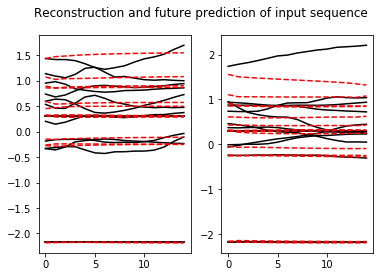

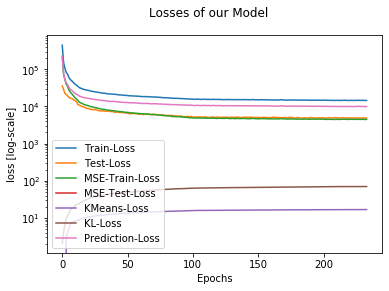

In [52]:
vame.evaluate_model(config, 'VAME')

Now its time to let the model infer the underlying behavioral structure of your data. This step will load your trained model and set it to inference mode. Here, only the trained encoder is used to infer the latent state structure from which in a second step the k-Means cluster will be segmented.

vame.behavior_segmentation(config, model_name='VAME', cluster_method='kmeans', n_cluster=[30])

As usual, the function takes as input your config file as well as the name of the model. There are two more parameters you can control. The first one is the cluster_method which is by default set to kmeans. It is however possible to use a Gaussian mixture model to cluster from the latent state vector by setting cluster_method='GMM'. We recommend to leave the kmeans setting for now.

The second parameter is a list of behavioral states you want to cluster. E.g. n_cluster=[30] or n_cluster=[15,30,45]. After inferring the latent vectors for every animal this will create a folder in the results part for every behavior video with the cluster size. In this way you can set multiple cluster sizes and later investigate which particular size brings the best results for your experiment.

In our paper we were using 30 behavioral states. This number can be higher or lower, depending on how much data you have at hand to train the model and on how coarse- or fine-grained you want to cluster your behavior. Note, that there will be a trade-off when you set the cluster number too high or too low.

A last important note is that the resulting motif labels are starting at the time_window / 2 frame. This means if you chose time_window = 30, your first motif label is the 15th frame of your video.

In [93]:
# if throws error, change the window_size from config
vame.behavior_segmentation(config, model_name='VAME', cluster_method='kmeans', n_cluster=[15, 20, 30])

Using CUDA
GPU active: True
GPU used: GeForce GTX 1080
Computing latent space for chr7_day3 
Computing latent space for chr8_day3 
Behavior segmentation via k-Means for 15 cluster.
Segmentation for file chr7_day3...
Segmentation for file chr8_day3...
Behavior segmentation via k-Means for 20 cluster.
Segmentation for file chr7_day3...
Segmentation for file chr8_day3...
Behavior segmentation via k-Means for 30 cluster.
Segmentation for file chr7_day3...
Segmentation for file chr8_day3...


After segmenting your pose estimation time series into discrete behavioral motifs its time to quantify the behavior in your experiment.

vame.behavior_quantification(config, model_name='VAME', cluster_method='kmeans', n_cluster=30)

This function will give you the distribution of the motif usage and a transition matrix between behavioral motifs. The results will be stored in the results folder for every video.

From here, you can take these results and start doing your own analysis for your experiment. Enjoy!

In [94]:
vame.behavior_quantification(config, model_name='VAME', cluster_method='kmeans', n_cluster=15)

In [61]:
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

config = r"C:\Users\serce\PycharmProjects\behaviour-switching\vame_onur-Nov26-2020\config.yaml"
latent = np.load(r"C:\Users\serce\PycharmProjects\behaviour-switching\vame_onur-Nov26-2020\results\chr7_day3\VAME\kmeans-15\latent_vector_chr7_day3.npy")
kmeans = np.load(r"C:\Users\serce\PycharmProjects\behaviour-switching\vame_onur-Nov26-2020\results\chr7_day3\VAME\kmeans-15\15_km_label_chr7_day3.npy")

In [63]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(StandardScaler().fit_transform(latent))

Text(0.5, 1.0, 'UMAP projection of the latent vectors')

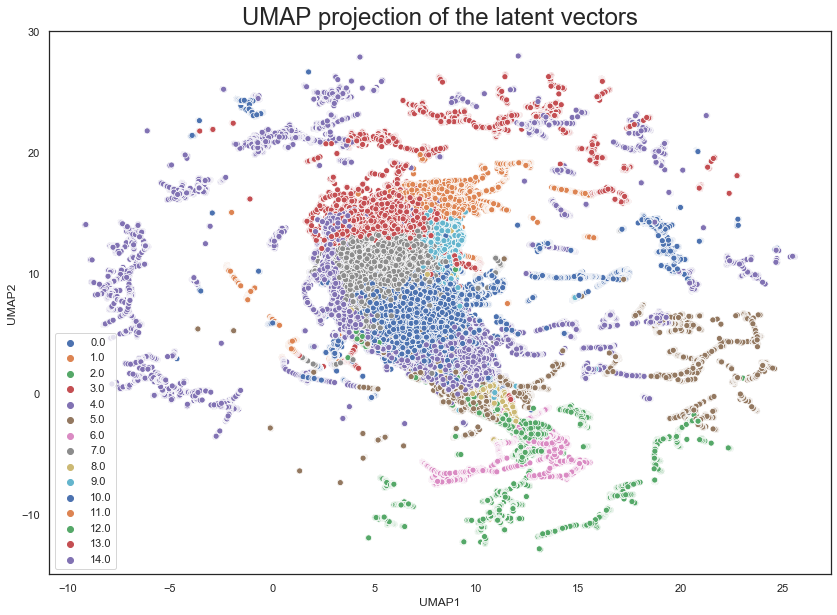

In [71]:
total_frames = 108000
skip = 108000-len(kmeans)

embedding_with_labels = np.column_stack((embedding[:, 0], embedding[:, 1], kmeans))


# plt.scatter(
#     embedding_with_labels[:, 0],
#     embedding_with_labels[:, 1],
#     c = embedding_with_labels[:, 2]
# )
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the latent vectors', fontsize=24)
# plt.legend()

sns.scatterplot(x=embedding_with_labels[:, 0], y=embedding_with_labels[:,1], hue=embedding_with_labels[:,2],
               palette='deep', legend='full')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP projection of the latent vectors', fontsize=24)

In [72]:
adjacency_matrix = np.load(r"C:\Users\serce\PycharmProjects\behaviour-switching\vame_onur-Nov26-2020\results\chr7_day3\VAME\kmeans-15\behavior_quantification\adjacency_matrix.npy")
motif_usage = np.load(r"C:\Users\serce\PycharmProjects\behaviour-switching\vame_onur-Nov26-2020\results\chr7_day3\VAME\kmeans-15\behavior_quantification\motif_usage.npy")
transition_matrix = np.load(r"C:\Users\serce\PycharmProjects\behaviour-switching\vame_onur-Nov26-2020\results\chr7_day3\VAME\kmeans-15\behavior_quantification\transition_matrix.npy")


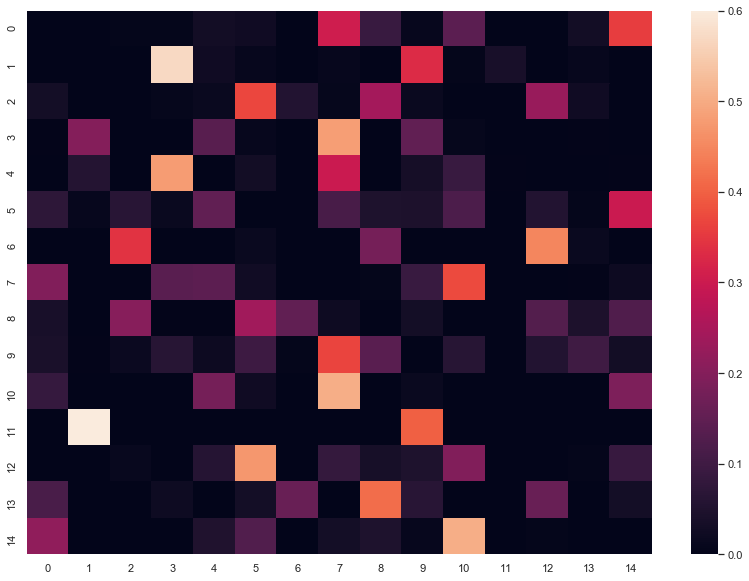

In [91]:
sns.heatmap(transition_matrix)